<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-30 07:54:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-05-30 07:54:06 (305 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: \ ^C
failed

CondaError: KeyboardInterrupt



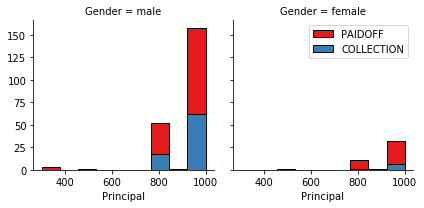

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

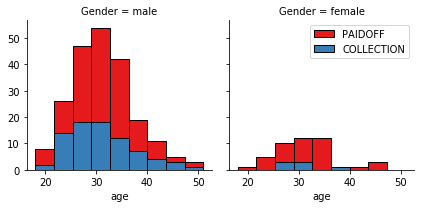

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

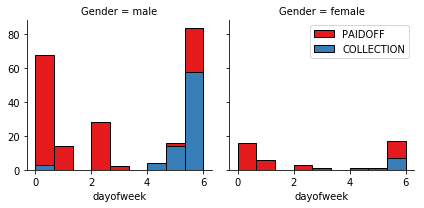

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
# Splitting the data sets into Train/Test
from sklearn.model_selection import train_test_split
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X, y, test_size=0.2, random_state=3)
print ('Train set:', X_train_KNN.shape,  y_train_KNN.shape)
print ('Test set:', X_test_KNN.shape,  y_test_KNN.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
# Importing KNN library
from sklearn.neighbors import KNeighborsClassifier
# Initilzing K and Traing the Model (Train Set)
k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train_KNN,y_train_KNN)
neigh
# Prediction with the Model (Test Set)
yhat_KNN = neigh.predict(X_test_KNN)
yhat_KNN

array(['PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

In [22]:
# Testing Model Accuracy
from sklearn import metrics
print("Train Accuracy is", metrics.accuracy_score(y_train_KNN,neigh.predict(X_train_KNN)))
print("Test Accuracy is", metrics.accuracy_score(y_test_KNN,yhat_KNN))

Train Accuracy is 0.8514492753623188
Test Accuracy is 0.6857142857142857


[0.6        0.64285714 0.67142857 0.68571429 0.64285714 0.64285714
 0.65714286 0.65714286 0.64285714]


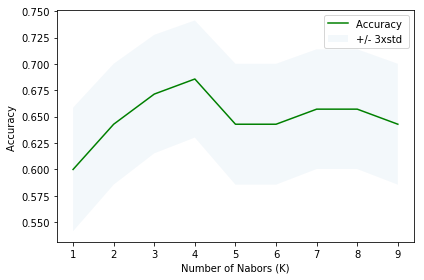

In [23]:
# Figuring out the best K for the model
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_KNN,y_train_KNN)
    yhat_KNN=neigh.predict(X_test_KNN)
    mean_acc[n-1] = metrics.accuracy_score(y_test_KNN, yhat_KNN)
    
    std_acc[n-1]=np.std(yhat_KNN==y_test_KNN)/np.sqrt(yhat_KNN.shape[0])

print(mean_acc)

# Plotting Accuracy vs. K
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.05)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# Decision Tree

In [82]:
# Data wrangling for Decision Tree
df_DT = df[['Principal','terms','age','Gender','education','weekend','loan_status']]
df_DT = df_DT.set_index('education')
df_DT.drop('Master or Above',inplace=True)
df_DT = df_DT.reset_index()
df_DT['education'].replace(to_replace=['High School or Below','college','Bechalor'], value=[0,1,2],inplace=True)
df_DT.head()

,education,Principal,terms,age,Gender,weekend,loan_status
0,0,1000,30,45,0,0,PAIDOFF
1,2,1000,30,33,1,0,PAIDOFF
2,1,1000,15,27,0,0,PAIDOFF
3,1,1000,30,28,1,1,PAIDOFF
4,1,1000,30,29,0,1,PAIDOFF


In [83]:
# Splitting the PREDICTOR variables from the TARGET variable
X_DT = df_DT[['Principal','terms','age','Gender','education','weekend']].values
y_DT = df_DT[['loan_status']].values

# Normalize the dataset
X_DT = preprocessing.StandardScaler().fit(X_DT).transform(X_DT)

# Splitting the data sets into Train/Test
from sklearn.model_selection import train_test_split
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.2, random_state=3)
print ('Train set:', X_train_DT.shape,  y_train_DT.shape)
print ('Test set:', X_test_DT.shape,  y_test_DT.shape)

Train set: (275, 6) (275, 1)
Test set: (69, 6) (69, 1)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [84]:
# Importing Decision Tree Library and setting up the Decision Tree
from sklearn.tree import DecisionTreeClassifier as DTC
loanTree = DTC(criterion="gini", max_depth = None)

# Training the Model
loanTree.fit(X_train_DT,y_train_DT)

# Predicting with the Model
yhat_DT = loanTree.predict(X_test_DT)
yhat_DT

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

In [27]:
# Testing Model Accuracy
from sklearn import metrics
print("Train Accuracy is", metrics.accuracy_score(y_train_DT,loanTree.predict(X_train_DT)))
print("Test Accuracy is", metrics.accuracy_score(y_test_DT,yhat_DT))

Train Accuracy is 0.9018181818181819
Test Accuracy is 0.6376811594202898


# Support Vector Machine

In [28]:
# Data wrangling for Support Vector Machine
df_SVM = df[['Principal','terms','age','Gender','education','weekend','loan_status']]
df_SVM = df_SVM.set_index('education')
df_SVM.drop('Master or Above',inplace=True)
df_SVM = df_SVM.reset_index()
df_SVM['education'].replace(to_replace=['High School or Below','college','Bechalor'], value=[0,1,2],inplace=True)
df_SVM['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'],value=[1,0],inplace=True)
df_SVM.head()

,education,Principal,terms,age,Gender,weekend,loan_status
0,0,1000,30,45,0,0,1
1,2,1000,30,33,1,0,1
2,1,1000,15,27,0,0,1
3,1,1000,30,28,1,1,1
4,1,1000,30,29,0,1,1


In [29]:
# Splitting the PREDICTOR variables from the TARGET variable
X_SVM = df_SVM[['Principal','terms','age','Gender','education','weekend']].values
y_SVM = df_SVM[['loan_status']].values

# Normalize the dataset
X_SVM = preprocessing.StandardScaler().fit(X_SVM).transform(X_SVM)

# Splitting the data sets into Train/Test
from sklearn.model_selection import train_test_split
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X_SVM, y_SVM, test_size=0.2, random_state=3)
print ('Train set:', X_train_SVM.shape,  y_train_SVM.shape)
print ('Test set:', X_test_SVM.shape,  y_test_SVM.shape)

Train set: (275, 6) (275, 1)
Test set: (69, 6) (69, 1)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
# Import SVM library and setting up the algorithm
from sklearn import svm
loan_SVM = svm.SVC(kernel='rbf')

# Training the Model
loan_SVM.fit(X_train_SVM, y_train_SVM) 

# Predicting with Model
yhat_SVM = loan_SVM.predict(X_test_SVM)
yhat_SVM

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [31]:
# Testing Model Accuracy
from sklearn import metrics
print("Train Accuracy is", metrics.accuracy_score(y_train_SVM,loan_SVM.predict(X_train_SVM)))
print("Test Accuracy is", metrics.accuracy_score(y_test_SVM,yhat_SVM))

Train Accuracy is 0.7563636363636363
Test Accuracy is 0.7971014492753623


# Logistic Regression

In [32]:
# The dataframe that will be used for Logistic Regression is the same as the one used for Support Vector Machine
df_LR = df_SVM
df_LR.head()

# Splitting the PREDICTOR variables from the TARGET variable
X_LR = df_LR[['Principal','terms','age','Gender','education','weekend']].values
y_LR = df_LR[['loan_status']].values

# Normalize the dataset
X_LR = preprocessing.StandardScaler().fit(X_LR).transform(X_LR)

# Splitting the data sets into Train/Test
from sklearn.model_selection import train_test_split
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_LR, y_LR, test_size=0.2, random_state=3)
print ('Train set:', X_train_LR.shape,  y_train_LR.shape)
print ('Test set:', X_test_LR.shape,  y_test_LR.shape)

Train set: (275, 6) (275, 1)
Test set: (69, 6) (69, 1)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
# Import SVM library and setting up the algorithm
from sklearn.linear_model import LogisticRegression
loan_LR = LogisticRegression(C=0.01, solver='liblinear')

# Training the Model
loan_LR.fit(X_train_LR,y_train_LR)

# Predicting with Model
yhat_LR = loan_LR.predict(X_test_LR)
yhat_LR

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [34]:
# Testing Model Accuracy
from sklearn import metrics
print("Train Accuracy is", metrics.accuracy_score(y_train_LR,loan_LR.predict(X_train_LR)))
print("Test Accuracy is", metrics.accuracy_score(y_test_LR,yhat_LR))

Train Accuracy is 0.730909090909091
Test Accuracy is 0.8115942028985508


# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-30 07:55:21--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-05-30 07:55:21 (167 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [70]:
# Data wrangling for the Test set
test_df = pd.read_csv('loan_test.csv')
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# Data wrangling for KNN evaluation - BUILDING THE DATASET
test_KNN = test_df[['Principal','terms','age','Gender','weekend','loan_status']]
test_KNN = pd.concat([test_KNN,pd.get_dummies(test_df['education'])], axis=1)
test_KNN.drop(['Master or Above'], axis = 1,inplace=True)

# Data wrangling for Decision Tree evaluation - BUILDING THE DATASET
test_DT = test_df[['Principal','terms','age','Gender','weekend','loan_status','education']]
test_DT = test_DT.set_index('education')
test_DT.drop('Master or Above',inplace=True)
test_DT = test_DT.reset_index()
test_DT['education'].replace(to_replace=['High School or Below','college','Bechalor'], value=[0,1,2],inplace=True)

# Data wrangling for Support Vector Machine evaluation - BUILDING THE DATASET
test_SVM = test_df[['Principal','terms','age','Gender','weekend','loan_status','education']]
test_SVM = test_SVM.set_index('education')
test_SVM.drop('Master or Above',inplace=True)
test_SVM = test_SVM.reset_index()
test_SVM['education'].replace(to_replace=['High School or Below','college','Bechalor'], value=[0,1,2],inplace=True)
test_SVM['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)

# Data wrangling for Logistic Regression evaluation - BUILDING THE DATASET
test_LR = test_SVM

In [71]:
# Dataset preparation for f1_score - KNN Evaluation
y_KNN_2 = test_KNN[['loan_status']]
y_KNN_2['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y_KNN_2 = y_KNN_2.astype('int')
y_KNN_2 = np.asarray(y_KNN_2)

In [75]:
# Dataset preparation for f1_score - Decision Tree Evaluation
y_DT_2 = test_DT[['loan_status']]
y_DT_2['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y_DT_2 = y_KNN_2.astype('int')
y_DT_2 = np.asarray(y_KNN_2)

### Evaluating K Neearest Neighbor

In [72]:
# Setting up the testing sets
X_KNN = test_KNN[['Principal','terms','age','Gender','weekend','Bechalor','High School or Below','college']].values
y_KNN = test_KNN[['loan_status']].values

# Normalize the dataset
X_KNN = preprocessing.StandardScaler().fit(X_KNN).transform(X_KNN)

# f1_Score inputs
yhat_KNN = neigh.predict(X_KNN)
yhat_KNN = np.where(yhat_KNN == 'PAIDOFF',1,np.where(yhat_KNN == 'COLLECTION',0,''))
yhat_KNN = yhat_KNN.astype('int')

print("The Jaccard Score is",jaccard_similarity_score(y_KNN,neigh.predict(X_KNN)))
print("The f1_Score is",f1_score(y_KNN_2,yhat_KNN))

The Jaccard Score is 0.7407407407407407
The f1_Score is 0.8444444444444444


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Evaluating Decision Tree

In [85]:
# Setting up the testing sets
X_DT = test_DT[['Principal','terms','age','Gender','weekend','education']].values
y_DT = test_DT[['loan_status']].values

# Normalize the dataset
X_DT = preprocessing.StandardScaler().fit(X_DT).transform(X_DT)

# f1_Score inputs
yhat_DT = loanTree.predict(X_DT)
yhat_DT = np.where(yhat_DT == 'PAIDOFF',1,np.where(yhat_DT == 'COLLECTION',0,''))
yhat_DT = yhat_KNN.astype('int')

print("The Jaccard Score is",jaccard_similarity_score(y_DT,loanTree.predict(X_DT)))
print("The f1_Score is",f1_score(y_DT_2,yhat_DT))

The Jaccard Score is 0.5384615384615384
The f1_Score is 0.8444444444444444


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Evaluating Support Vector Maching

In [90]:
# Setting up the testing sets
X_SVM = test_SVM[['Principal','terms','age','Gender','weekend','education']].values
y_SVM = test_SVM[['loan_status']].values

# Normalize the dataset
X_SVM = preprocessing.StandardScaler().fit(X_SVM).transform(X_SVM)

print("The Jaccard Score is",jaccard_similarity_score(y_SVM,loan_SVM.predict(X_SVM)))
print("The f1_Score is",f1_score(y_SVM,loan_SVM.predict(X_SVM)))

The Jaccard Score is 0.7307692307692307
The f1_Score is 0.8444444444444443


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Evaluating Logistic Regression

In [96]:
# Setting up the testing sets
X_LR = test_LR[['Principal','terms','age','Gender','weekend','education']].values
y_LR = test_LR[['loan_status']].values

# Normalize the dataset
X_LR = preprocessing.StandardScaler().fit(X_LR).transform(X_LR)

print("The Jaccard Score is",jaccard_similarity_score(y_LR,loan_LR.predict(X_LR)))
print("The f1_Score is",f1_score(y_LR,loan_LR.predict(X_LR)))
print("The log loss is", log_loss(y_LR,loan_LR.predict(X_LR)))

The Jaccard Score is 0.5961538461538461
The f1_Score is 0.746987951807229
The log loss is 13.948567281868216


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Report

In [107]:
Report = {'Algorithm':['KNN','Decision Tree','SVM','LogisticRegression'],
          'Jaccard':[jaccard_similarity_score(y_KNN,neigh.predict(X_KNN)),jaccard_similarity_score(y_DT,loanTree.predict(X_DT)),
                   jaccard_similarity_score(y_SVM,loan_SVM.predict(X_SVM)),jaccard_similarity_score(y_LR,loan_LR.predict(X_LR))],
         'F1-score':[f1_score(y_KNN_2,yhat_KNN),f1_score(y_DT_2,yhat_DT),f1_score(y_SVM,loan_SVM.predict(X_SVM)),
                    f1_score(y_LR,loan_LR.predict(X_LR))],
         'LogLoss':['NA','NA','NA',log_loss(y_LR,loan_LR.predict(X_LR))]}
Report = pd.DataFrame(Report)
Report.set_index('Algorithm')

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.740741,0.844444,NA
Decision Tree,0.538462,0.844444,NA
SVM,0.730769,0.844444,NA
LogisticRegression,0.596154,0.746988,13.9486


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>